In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
import re
import sys
import pickle as pkl
from nltk.corpus import stopwords
import collections
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_validate

<h2><b> 1. Data preprocessing/cleanup </b></h2>
We have to firstly read the .pkl file and save the data in a dataframe.
Then we convert all the tweets into lowercase and remove stopwords, URLs,
hashtags, @, punctuation and emojis.

In [3]:
# Question 1

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Read .pkl file
df = pd.read_pickle('eclass_all_with_sentiment_v2.pkl')

# Set to lowercase
df = df.apply(lambda x: x.astype(str).str.lower())

# Remove stopwords
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

# Remove URLs
df["text"] = df["text"].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#Remove hashtags ('#')
df["text"] = df["text"].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", str(x)))

# Remove ats ('@')
df["text"] = df["text"].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", str(x)))

# Remove punctuation
df["text"] = df["text"].str.translate(str.maketrans('','',string.punctuation))

# Remove emojis
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

<h3><b> Creating training and test sets </b></h3>
Training set: 80% of data
<br>
Test set: 20% of data
<br>
After we split the data we save it in two files, 'train.tsv' and 'test.tsv'

In [4]:
# Spliting dataframe in training and test sets
train_size = int(len(df)*0.8)
test_size = len(df) - train_size;

tf_train = df.iloc[:2000]
tf_test = df.iloc[2000:2200]

tf_train.to_csv('train.tsv',  index = False , sep="\t")
tf_test.to_csv('test.tsv', index = False, sep="\t")

-----

<h2><b> 2. Analyzing the data </b></h2>
<h3><b> Number of positive/negative/neutral tweets </b></h3>
The first thing we do is to find how many positive, negative and neutral tweets
there are in total.

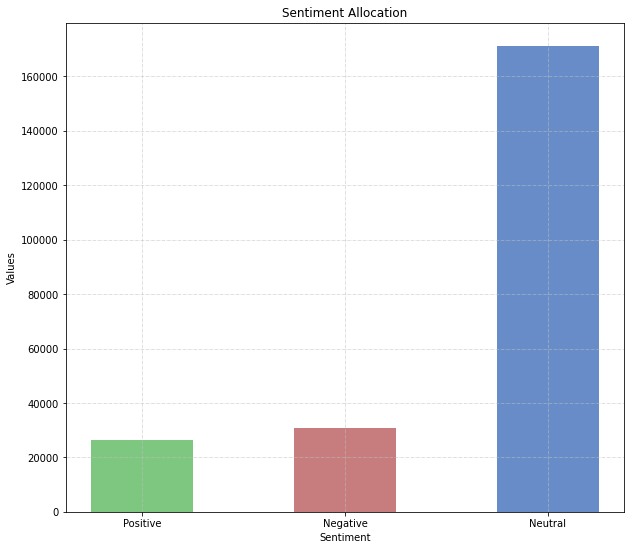

In [ ]:
# Question 2 Sub-question i)

pos = 0 
neg = 0
neut = 0

# Count the occurences of every sentiment in the 'sentiment' column of the dataframe
last_column = df.iloc[: , -1]
for val in last_column:
  if(val == "pos"):
    pos+=1
  elif(val == "neg"):
    neg+=1
  elif(val == "neu"):
    neut+=1

# Create the dataset
data = {'Positive':pos, 'Negative':neg, 'Neutral':neut}
sentiment = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 9))
 
# Create a bar plot
plt.bar(sentiment[0], values[0], color ='#7dc781', width = 0.5)
plt.bar(sentiment[1], values[1], color ='#c77d7d', width = 0.5)
plt.bar(sentiment[2], values[2], color ='#678cc7', width = 0.5)

plt.xlabel("Sentiment")
plt.ylabel("Values")
plt.title("Sentiment Allocation")

plt.grid(linestyle='-.', linewidth=0.5 , color='silver', fillstyle='full')
plt.show()

<h3><b> Most common words used in tweets </b></h3>
We find the words that appear most frequently.

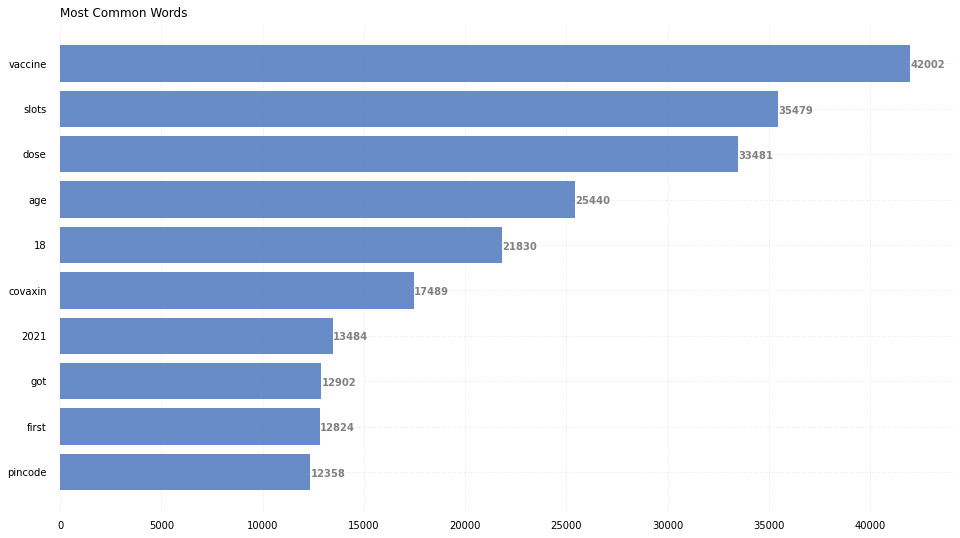

In [ ]:
# Question 2 Sub-question ii)

# The maximum number of common words that will be displayed
max_display = 10

# Get all the words from the dataset
words = []
for row in df["text"]:
  word = row.split()
  words.extend(word)

# Get the words that appear more frequently
counter = collections.Counter(words)
most_common_words = counter.most_common(max_display)
common_dict = dict(most_common_words)

# Create a bar plot to show the most common words
fig, ax = plt.subplots(figsize =(16, 9))
 
ax.barh(list(common_dict.keys()), list(common_dict.values()), color="#678cc7")

# Make some small changes to the bar plot's appearance
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
 
# Show higher values first
ax.invert_yaxis()
 
# Add the values next to the bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 10, fontweight ='bold', color ='grey')
 
ax.set_title('Most Common Words', loc ='left')

plt.show()

<h3><b> Most common words in positive, negative and neutral tweets </b></h3>
We find the words that appear most frequently in each category of tweets.


In [ ]:
# Function that makes a custom bar plot
def BarGraphFunction(width, height, y_values, x_values, title, bar_color):
  
  fig, ax = plt.subplots(figsize =(width, height))
  
  ax.barh(x_values, y_values, color = bar_color)
  
  # Make some small changes to the bar plot's appearance
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
  
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
  
  ax.grid(b = True, color ='white',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)
  
  # Show higher values first
  ax.invert_yaxis()
  
  # Show the value of each bar
  for i in ax.patches:
      plt.text(i.get_width()-50, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 10, fontweight ='bold', ha='right', color='white')
  
  ax.set_facecolor('#2e2e2e')
  ax.tick_params(colors='white', which='both')
  fig.patch.set_facecolor('#2e2e2e')
  ax.set_title(title, fontsize=16, loc ='left', fontweight ='bold' , color='white')
  plt.xlabel("Words Counted", fontweight ='bold', color='grey')
  plt.ylabel("Words", fontweight ='bold', color='grey')

  plt.show()

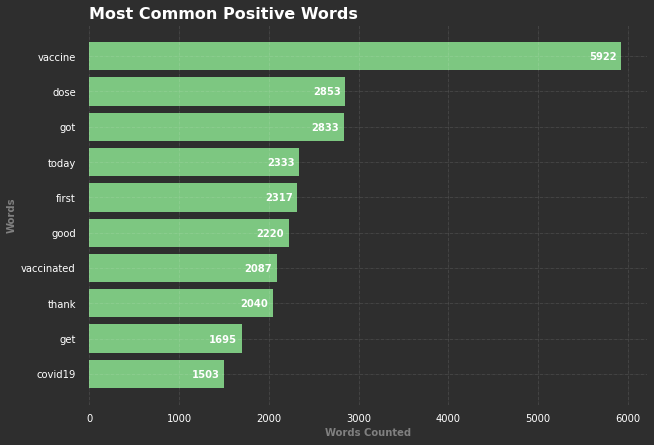

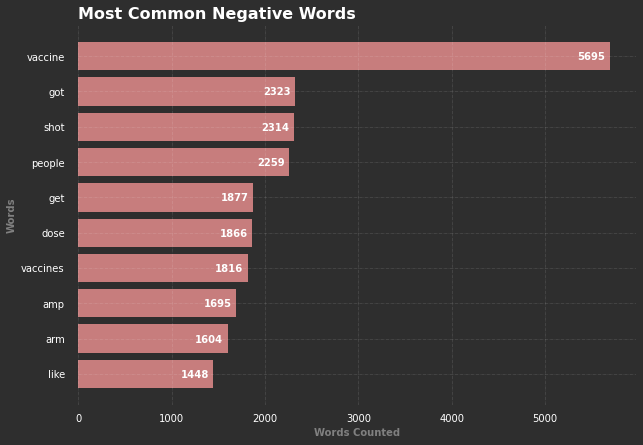

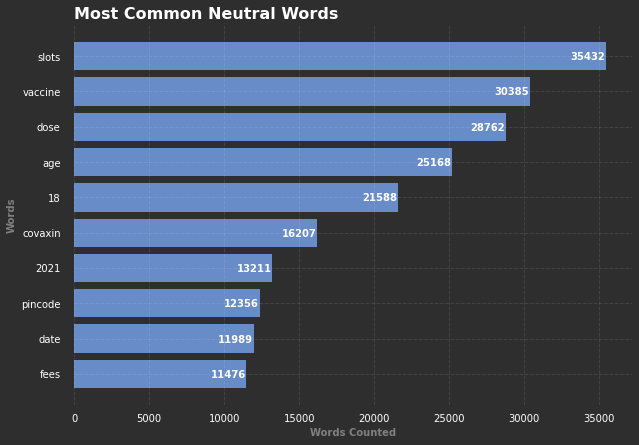

In [ ]:
# Question 2 Sub-question iii)

# The maximum number of common words that will be displayed
max_display = 10
i = 0

pos_words = []
neg_words = []
neut_words = []

last_column = df.iloc[: , -1]

# Get all the words from every category of tweets
for row in df["text"]:
  if(last_column[i] == "pos"):
    pos_word = row.split()
    pos_words.extend(pos_word)
  elif(last_column[i] == "neg"):
    neg_word = row.split()
    neg_words.extend(neg_word)
  elif(last_column[i] == "neu"):
    neut_word = row.split()
    neut_words.extend(neut_word)
  i=i+1

# Get the words that appear more frequently in positive tweets
counter_pos = collections.Counter(pos_words)
most_common_positive_words = counter_pos.most_common(max_display)
pos_common_dict = dict(most_common_positive_words)

# Get the words that appear more frequently in negative tweets
counter_neg = collections.Counter(neg_words)
most_common_negative_words = counter_neg.most_common(max_display)
neg_common_dict = dict(most_common_negative_words)

# Get the words that appear more frequently in neutral tweets
counter_neut = collections.Counter(neut_words)
most_common_neutral_words = counter_neut.most_common(max_display)
neut_common_dict = dict(most_common_neutral_words)

# Create bar plots to show the most common words
BarGraphFunction(10, 7, list(pos_common_dict.values()), list(pos_common_dict.keys()), "Most Common Positive Words", "#7dc781")
BarGraphFunction(10, 7, list(neg_common_dict.values()), list(neg_common_dict.keys()), "Most Common Negative Words", "#c77d7d")
BarGraphFunction(10, 7, list(neut_common_dict.values()), list(neut_common_dict.keys()), "Most Common Neutral Words", "#678cc7")

<h3><b> Tweets that contain the names of the vaccines </b></h3>
We create a subset of tweets that contain the word 'astrazeneca' and another subset of tweets that contain the words 'moderna', 'pfizer' or 'biontech'.
<br>
Then we compare the two subsets based on how many positive, negative and neutral tweets they contain.

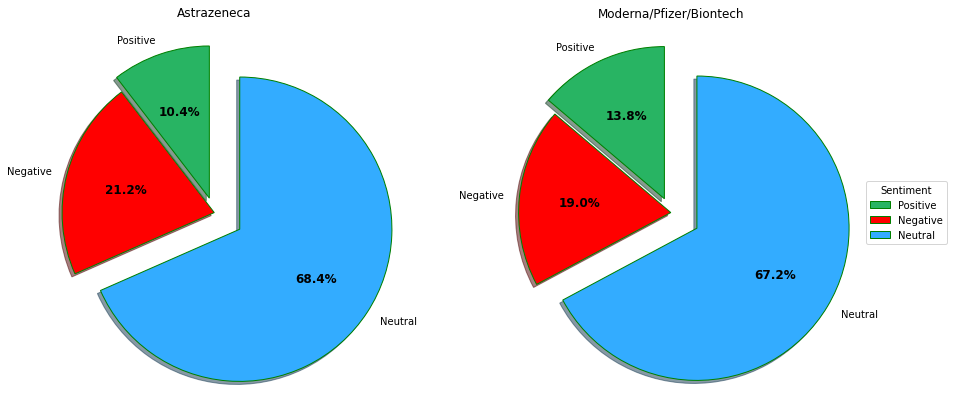

In [ ]:
# Question 2 Sub-question iv)

astraPos, astraNeg, astraNeu = 0, 0, 0
modPfizPos, modPfizNeg, modPfizNeu = 0, 0, 0
vaccNames = ["moderna", "pfizer", "biontech"]

# For every tweet that contains the words "astrazeneca" or "moderna"/"pfizer"/"biontech" check the sentiment of that tweet
for row in df.itertuples():
  if "astrazeneca" in row.text:
    if row.sentiment == "pos":
      astraPos+=1
    if row.sentiment == "neg":
      astraNeg+=1
    if row.sentiment == "neu":
      astraNeu+=1
  if any(vacc in row.text for vacc in vaccNames):
    if row.sentiment == "pos":
      modPfizPos+=1
    if row.sentiment == "neg":
      modPfizNeg+=1
    if row.sentiment == "neu":
      modPfizNeu+=1

# Create two pie charts to show the sentiment of the tweets that contain these specific words
sent = ['Positive', 'Negative', 'Neutral']
 
data1 = [astraPos, astraNeg, astraNeu]
data2 = [modPfizPos, modPfizNeg, modPfizNeu] 

explode = (0.1, 0.0, 0.2)
 
colors = ("#28B463", "red", "#33ACFF")

wp = {'linewidth' : 1, 'edgecolor' : "green"}

# Pie chart for the tweets that contain the word "astrazeneca"
plt.subplot(1,2,1)
wedges, texts, autotexts = plt.pie(data1,
                                  explode = explode,
                                  labels = sent,
                                  autopct='%1.1f%%',
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp)

plt.setp(autotexts, size = 12, weight ="bold")
plt.title("Astrazeneca")

# Pie chart for the tweets that contain the words "moderna", "pfizer" or "biontech"
plt.subplot(1,2,2)
wedges, texts, autotexts = plt.pie(data2,
                                  explode = explode,
                                  labels = sent,
                                  autopct='%1.1f%%',
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp)

plt.setp(autotexts, size = 12, weight ="bold")
plt.title("Moderna/Pfizer/Biontech")

plt.legend(wedges, sent,
          title ="Sentiment",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

fig = plt.gcf()
fig.set_size_inches(15, 9)

plt.show()

<h3><b> Number of tweets per month </b></h3>
We find how many tweets were posted each month.
<br>
For the months with the most tweets we also mention if any important events happened during these months.

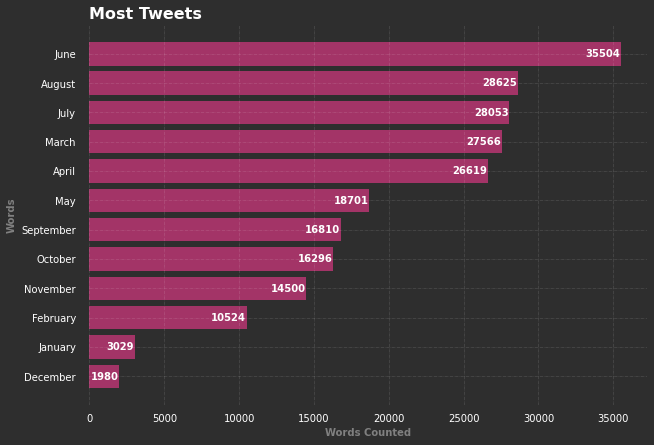

In [ ]:
# Question 2 Sub-question v)

count = 0
resultsList = [0]*12
i = 0

# Function that takes a list and increases the value of a specific index by one 
def dynamicAppendList(lista, index, value):
  if not lista:
    lista[index] = value
  else:
    lista[index] = lista[index] + value
  return lista


# For each month we count all the tweets
for row in df.itertuples():
  date_time_formated = row.date.replace("-", "/")
  date_time = datetime.strptime(date_time_formated, '%Y/%m/%d %H:%M:%S')
  res = dynamicAppendList(resultsList, date_time.month-1, 1);
  
# Create a list with all the months
months = []
for month in calendar.month_name:
  if not month:
    continue
  months.append(month)

# Create a dictionary with keys and values of months and tweets 
resDict = {}
for key in months:
    for value in res:
        resDict[key] = value
        res.remove(value)
        break

# Sort the dictionary based on values
sorted_dict = {}
sorted_keys = sorted(resDict, key=resDict.get)  
for w in sorted_keys:
    sorted_dict[w] = resDict[w]

# Get the months with the most tweets
max = 12
inverted = {}
for x in list(reversed(list(sorted_dict)))[0:max]:
  inverted[x] = sorted_dict[x]

# Create a bar plot that shows the months with the most tweets
BarGraphFunction(10, 7, list(inverted.values()), list(inverted.keys()), "Most Tweets", "#dc3783ad")

The results show that more tweets were posted during March, April, June, July and August of 2021 compared to other months. Some important events that happened during these months are the following:
<br> <br>
<u><b> March 2021 </u></b>: Several countries suspend dispensing AstraZeneca COVID vaccine over concerns of blood clotting.
<br>
<u><b> April 2021 </u></b>: CDC recommends pausing the use of the Johnson & Johnson (J&J) COVID-19 vaccine because of blood clot complications. CDC also announces that fully vaccinated individuals can travel safely domestically in the U.S. without a COVID test first.
<br>
<u><b> June 2021 </b></u>: The delta variant becomes the dominant variant in the United States. The variant kicks off a third wave of infections during the summer of 2021.
<br>
<u><b> July 2021 </u></b>: The FDA warns that the COVID-19 vaccine manufactured by Johnson & Johnson (J&J) can lead to an increased risk of Guillain-Barré syndrome. Also, new research shows that the Pfizer vaccine is not as effective against the delta variant.
<br>
<u><b> August 2021 </u></b>: Pfizer/BioNTech vaccine gains full FDA approval and vaccine mandates for workers are announced in the United States.
<br> <br>
<b> Sources: </b>
<br> https://www.cdc.gov/museum/timeline/covid19.html
<br> https://www.ajmc.com/view/a-timeline-of-covid-19-vaccine-developments-in-2021
<br> https://www.ajmc.com/view/a-timeline-of-covid-19-vaccine-developments-for-the-second-half-of-2021
<br> <br>
<hr>


<h3><b> Average number of favorites and retweets </b></h3>
We will compare the average number of favorites and retweets that a positive, negative or neutral tweet gets.

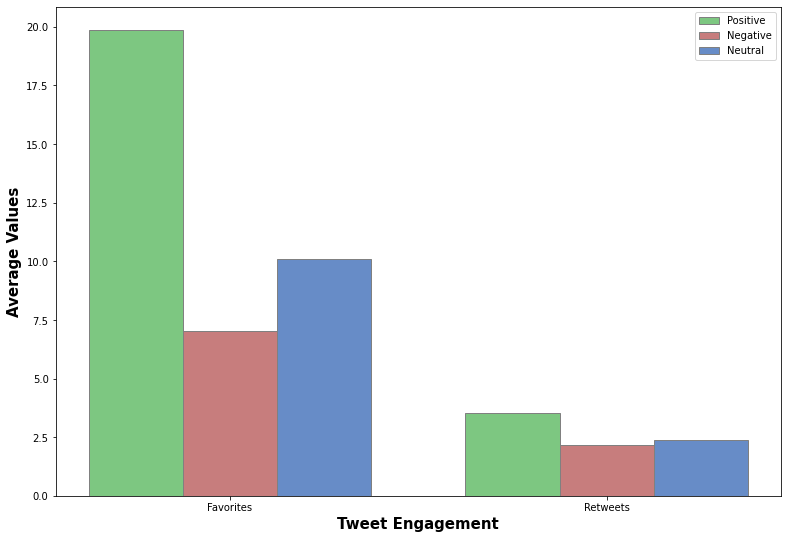

In [ ]:
# Question 2 Sub-question vi)

posFavor, negFavor, neuFavor = 0, 0, 0
posRetweets, negRetweets, neuRetweets = 0, 0, 0

# For every tweet check its sentiment and the number of favorites and retweets it has
for row in df.itertuples():
  if row.sentiment == "pos":
    posFavor += int(row.favorites)
    posRetweets += int(row.retweets)
  if row.sentiment == "neg":
    negFavor += int(row.favorites)
    negRetweets += int(row.retweets)
  if row.sentiment == "neu":
    neuFavor += int(row.favorites)
    neuRetweets += int(row.retweets)

# Find the average number of favorites and retweets that a positive, negative or neutral tweet gets
posFavorAvg = float(posFavor) / pos
posRetweetsAvg = float(posRetweets) / pos

negFavorAvg = float(negFavor) / neg
negRetweetsAvg = float(negRetweets) / neg

neuFavorAvg = float(neuFavor) / neut
neuRetweetsAvg = float(neuRetweets) / neut

# Create a bar plot to show the average number of favorites and retweets
fig = plt.subplots(figsize =(13, 9))

posEngagement = [posFavorAvg, posRetweetsAvg]
negEngagement = [negFavorAvg, negRetweetsAvg]
neuEngagement = [neuFavorAvg, neuRetweetsAvg]

br = np.arange(len(posEngagement))

plt.bar(br, posEngagement, color ='#7dc781', width = 0.25, edgecolor ='grey', label ='Positive')
plt.bar(br + 0.25, negEngagement, color ='#c77d7d', width = 0.25, edgecolor ='grey', label ='Negative')
plt.bar(br + 0.50, neuEngagement, color ='#678cc7', width = 0.25, edgecolor ='grey', label ='Neutral')

plt.xlabel('Tweet Engagement', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Values', fontweight ='bold', fontsize = 15)
plt.xticks(br + 0.25, ['Favorites', 'Retweets'])
 
plt.legend()
plt.show()

<h3><b> Number of negative tweets posted each month </b></h3>
We compare the number of negative tweets for every month.

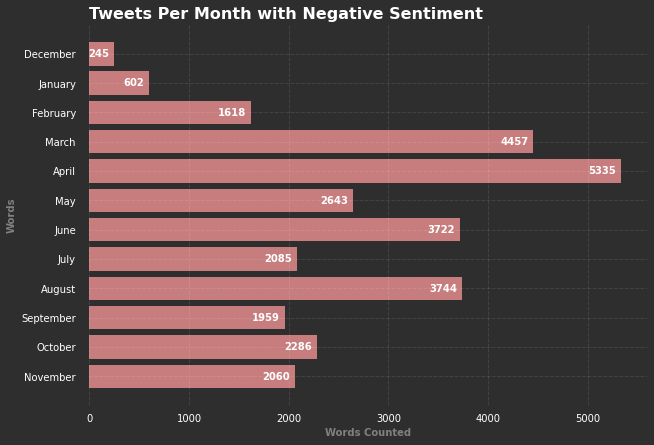

In [ ]:
# Question 2 Sub-question vi)

count = 0
resultsList = [0]*12
i = 0

# Function that takes a list and increases the value of a specific index by one
def dynamicAppendList(lista, index, value):
  if not lista:
    lista[index] = value
  else:
    lista[index] = lista[index] + value
  return lista

# For each month we count all the tweets
for row in df.itertuples():
  if row.sentiment == "neg":
    date_time_formated = row.date.replace("-", "/")
    date_time = datetime.strptime(date_time_formated, '%Y/%m/%d %H:%M:%S')
    res = dynamicAppendList(resultsList, date_time.month-1, 1);
  
# Create a list with all the months
months = []
for month in calendar.month_name:
  if not month:
    continue
  months.append(month)

# Create a dictionary with keys and values of months and tweets 
resDict = {}
for key in months:
    for value in res:
        resDict[key] = value
        res.remove(value)
        break

lst = list(resDict.values())[-1] # Keep last value
resDict.popitem() # Remove December
Dict = {"December" : lst} 
Dict.update(resDict) # Make December the first one

# Create a bar plot that shows all the negative tweets for each month
BarGraphFunction(10, 7, list(Dict.values()), list(Dict.keys()), "Tweets Per Month with Negative Sentiment", "#c77d7d")

-----

<h2><b> 3. Vectorization </b></h2>
<h3><b> Bag-of-words </b></h3>


In [5]:
# Get a list of the tweets from the training and test set
tweets_train_list = tf_train['text'].tolist()
tweets_test_list = tf_test['text'].tolist()

# Create a bag-of-words representation of the tweets
bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=500, stop_words='english')

bow_xtrain = bow_vectorizer.fit_transform(tweets_train_list)
bow_xtest = bow_vectorizer.fit_transform(tweets_test_list)

# Convert the results to dataframes
bow_train_df = pd.DataFrame(bow_xtrain.toarray())
bow_test_df = pd.DataFrame(bow_xtest.toarray())

<h3><b> Tf-idf </b></h3>





In [6]:
# Create a Tf-idf representation of the tweets
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=500, stop_words='english')

tfidf_xtrain = tfidf_vectorizer.fit_transform(tweets_train_list)
tfidf_xtest = tfidf_vectorizer.fit_transform(tweets_test_list)

# Convert the results to dataframes
tfidf_train_df = pd.DataFrame(tfidf_xtrain.toarray())
tfidf_test_df = pd.DataFrame(tfidf_xtest.toarray())

<h3><b> Word embeddings </b></h3>

In [7]:
model_wemb = {}

# Read the file with the pre-trained word vectors
with open("/content/drive/MyDrive/ΤΕΔΕ/glove.twitter.27B.100d.txt",'r') as f:
    for line in f:
        split_line = line.split()
        word = split_line[0]
        embedding = np.array(split_line[1:], dtype=np.float64)
        model_wemb[word] = embedding

print(f"{len(model_wemb)} words loaded!")

1193515 words loaded!


In [8]:
tweets_train_wemb = np.zeros(shape=(len(tf_train), 100))
tweets_test_wemb = np.zeros(shape=(len(tf_test), 100))

# For every tweet this function calculates the average of the vectors of the words present in the tweet
def word_emb(dtf, tweets_wemb, model_wemb):
  i = 0

  for tweet in dtf['text']:
    tweet_vector = np.zeros(shape=(100,))
    num_words = 0
    split_tweet = tweet.split()

    # Check if the word exists in the pre-trained word vectors
    for word in split_tweet:
      if word in model_wemb:
        tweet_vector = tweet_vector + model_wemb[word]
        num_words += 1
    
    if num_words != 0:
      tweet_vector = tweet_vector / num_words
    
    tweets_wemb[i] = tweet_vector

    i += 1

# Get the word vectors for all the tweets in the training and test sets
word_emb(tf_train, tweets_train_wemb, model_wemb)
word_emb(tf_test, tweets_test_wemb, model_wemb)



------
## <b> 4. Classifying tweets </b>
We will use 3 different classifiers in order to predict the sentiment of the tweets in the dataset.


In [9]:
# Function that uses 10-fold Cross Validation to assess how well each classification method performs
def CrossValidationScore(title, model, X , y):

  kf = KFold(n_splits=10, random_state=None)
  acc_score = []
  prec_score = []
  rec_score = []
  f_score = []

  for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)

    prec = precision_score(pred_values , y_test, average='macro')
    prec_score.append(prec)

    rec = recall_score(pred_values , y_test, average='macro')
    rec_score.append(rec)

    f1 = f1_score(pred_values , y_test, average='macro')
    f_score.append(f1)


  avg_acc_score = sum(acc_score)/10
  avg_prec_score = sum(prec_score)/10
  avg_rec_score = sum(rec_score)/10
  avg_f1_score = sum(f_score)/10

  print(title)
  print("Avg accuracy: ", avg_acc_score)
  print("Avg precision: ", avg_prec_score)
  print("Avg recall: " ,avg_rec_score)
  print("Avg f1: ", avg_f1_score, "\n")

### <b> SVM </b>
The first method that we are going to use is the SVM classifier.
<br>
We will train a model using this algorithm and we will assess its predictions on the test set.

In [28]:
# Using the SVM classifier with a 'bag-of-words' representation of the dataset
cross_bow_svm = svm.SVC(gamma=0.001, C=100.)
# Perform cross validation
#CrossValidationScore("Average Cross Validation Scores for Bag-of-words SVM Classifier", cross_bow_svm, bow_train_df, tf_train['sentiment'])
kf = KFold(n_splits=10, random_state=None)

scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro',
           'f1': 'f1_macro'}

scores = cross_validate(cross_bow_svm , bow_train_df, tf_train['sentiment'], cv = kf, scoring=scoring)

print("Average Cross Validation Scores for Bag-of-words SVM Classifier")
print("Avg accuracy: ", scores['test_acc'].mean())
print("Avg precision: ", scores['test_prec'].mean())
print("Avg recall: ", scores['test_rec'].mean())
print("Avg f1: ", scores['test_f1'].mean())

# Train the model and perform predictions
bow_svm = svm.SVC(gamma=0.001, C=100.)
bow_svm.fit(bow_train_df, tf_train['sentiment'])
bow_svm_pred = bow_svm.predict(bow_test_df)


# Using the SVM classifier with a 'Tf-idf' representation of the dataset
tfidf_svm = svm.SVC(gamma=0.001, C=100.)

# Train the model and perform predictions
tfidf_svm.fit(tfidf_xtrain, tf_train['sentiment'])
tfidf_svm_pred = tfidf_svm.predict(tfidf_test_df)


# Using the SVM classifier with a 'word embeddings' representation of the dataset
wemb_svm = svm.SVC(gamma=0.001, C=100.)

# Train the model and perform predictions
wemb_svm.fit(tweets_train_wemb, tf_train['sentiment'])
wemb_svm_pred = wemb_svm.predict(tweets_test_wemb)

Average Cross Validation Scores for Bag-of-words SVM Classifier
Avg accuracy:  0.7625
Avg precision:  0.7717143834086932
Avg recall:  0.5086104472208861
Avg f1:  0.5381855709812


In [17]:
# Print all the important metrics for every model
print("SVM with bag-of-words")
print(classification_report(tf_test['sentiment'], bow_svm_pred, digits=3) + "\n\n")

print("SVM with Tf-idf")
print(classification_report(tf_test['sentiment'], tfidf_svm_pred, digits=3) + "\n\n")

print("SVM with word embeddings")
print(classification_report(tf_test['sentiment'], wemb_svm_pred, digits=3))

SVM with bag-of-words
              precision    recall  f1-score   support

         neg      0.500     0.028     0.053        36
         neu      0.672     0.938     0.783       129
         pos      0.222     0.114     0.151        35

    accuracy                          0.630       200
   macro avg      0.465     0.360     0.329       200
weighted avg      0.562     0.630     0.541       200



SVM with Tf-idf
              precision    recall  f1-score   support

         neg      0.000     0.000     0.000        36
         neu      0.650     0.992     0.785       129
         pos      0.667     0.057     0.105        35

    accuracy                          0.650       200
   macro avg      0.439     0.350     0.297       200
weighted avg      0.536     0.650     0.525       200



SVM with word embeddings
              precision    recall  f1-score   support

         neg      0.600     0.083     0.146        36
         neu      0.740     0.969     0.839       129
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### <b> Random Forest </b>
The second method that we are going to use is the Random Forest classifier.

In [29]:
# Using the Random Forests classifier with a 'bag-of-words' representation of the dataset
cross_bow_rf = RandomForestClassifier(n_estimators=100)
# Perform cross validation
#CrossValidationScore("Average Cross Validation Scores for Bag-of-words Random Forest Classifier", cross_bow_rf, bow_train_df, tf_train['sentiment'])
kf = KFold(n_splits=10, random_state=None)

scores = cross_validate(cross_bow_rf , bow_train_df, tf_train['sentiment'], cv = kf, scoring=scoring)

print("Average Cross Validation Scores for Bag-of-words Random Forest Classifier")
print("Avg accuracy: ", scores['test_acc'].mean())
print("Avg precision: ", scores['test_prec'].mean())
print("Avg recall: ", scores['test_rec'].mean())
print("Avg f1: ", scores['test_f1'].mean())

# Train the model and perform predictions
bow_rf = RandomForestClassifier(n_estimators=100)
bow_rf.fit(bow_train_df, tf_train['sentiment'])
bow_rf_pred = bow_rf.predict(bow_test_df)


# Using the Random Forests classifier with a 'Tf-idf' representation of the dataset
tfidf_rf = RandomForestClassifier(n_estimators=100)

# Train the model and perform predictions
tfidf_rf.fit(tfidf_train_df, tf_train['sentiment'])
tfidf_rf_pred = tfidf_rf.predict(tfidf_test_df)


# Using the Random Forests classifier with a 'word embeddings' representation of the dataset
wemb_rf = RandomForestClassifier(n_estimators=100)

# Train the model and perform predictions
wemb_rf.fit(tweets_train_wemb, tf_train['sentiment'])
wemb_rf_pred = wemb_rf.predict(tweets_test_wemb)

Average Cross Validation Scores for Bag-of-words Random Forest Classifier
Avg accuracy:  0.7250000000000001
Avg precision:  0.6050862011494158
Avg recall:  0.5569232623281216
Avg f1:  0.5712485660159834


In [13]:
# Print all the important metrics for every model
print("Random Forests with bag-of-words")
print(classification_report(tf_test['sentiment'], bow_rf_pred, digits=3) + "\n\n")

print("Random Forests with Tf-idf")
print(classification_report(tf_test['sentiment'], tfidf_rf_pred, digits=3) + "\n\n")

print("Random Forests with word embeddings")
print(classification_report(tf_test['sentiment'], wemb_rf_pred, digits=3))

Random Forests with bag-of-words
              precision    recall  f1-score   support

         neg      0.184     0.194     0.189        36
         neu      0.669     0.659     0.664       129
         pos      0.143     0.143     0.143        35

    accuracy                          0.485       200
   macro avg      0.332     0.332     0.332       200
weighted avg      0.490     0.485     0.487       200



Random Forests with Tf-idf
              precision    recall  f1-score   support

         neg      0.182     0.056     0.085        36
         neu      0.677     0.876     0.764       129
         pos      0.227     0.143     0.175        35

    accuracy                          0.600       200
   macro avg      0.362     0.358     0.341       200
weighted avg      0.509     0.600     0.538       200



Random Forests with word embeddings
              precision    recall  f1-score   support

         neg      0.000     0.000     0.000        36
         neu      0.699     0

### <b> KNN </b>
The third and final method that we are going to use is the K-Nearest Neighbors classifier.

In [30]:
# Using the KNN classifier with a 'bag-of-words' representation of the dataset
cross_bow_knn = KNeighborsClassifier(n_neighbors = 3)
# Perform cross validation
#CrossValidationScore("Average Cross Validation Scores for Bag-of-words KNN Classifier", cross_bow_knn, bow_train_df, tf_train['sentiment'])
kf = KFold(n_splits=10, random_state=None)

scores = cross_validate(cross_bow_knn , bow_train_df, tf_train['sentiment'], cv = kf, scoring=scoring)

print("Average Cross Validation Scores for Bag-of-words KNN Classifier")
print("Avg accuracy: ", scores['test_acc'].mean())
print("Avg precision: ", scores['test_prec'].mean())
print("Avg recall: ", scores['test_rec'].mean())
print("Avg f1: ", scores['test_f1'].mean())

# Train the model and perform predictions
bow_knn = KNeighborsClassifier(n_neighbors = 3)
bow_knn.fit(bow_train_df, tf_train['sentiment'])
bow_knn_pred = bow_knn.predict(bow_test_df)


# Using the KNN classifier with a 'Tf-idf' representation of the dataset
tfidf_knn = KNeighborsClassifier(n_neighbors = 3)

# Train the model and perform predictions
tfidf_knn.fit(bow_train_df, tf_train['sentiment'])
tfidf_knn_pred = tfidf_knn.predict(tfidf_test_df)


# Using the KNN classifier with a 'word embeddings' representation of the dataset
wemb_knn = RandomForestClassifier(n_estimators=100)

# Train the model and perform predictions
wemb_knn.fit(tweets_train_wemb, tf_train['sentiment'])
wemb_knn_pred = wemb_knn.predict(tweets_test_wemb)

Average Cross Validation Scores for Bag-of-words KNN Classifier
Avg accuracy:  0.673
Avg precision:  0.5735257235461059
Avg recall:  0.39459190420063267
Avg f1:  0.3875306806752138


In [19]:
# Print all the important metrics for every model
print("KNN with bag-of-words")
print(classification_report(tf_test['sentiment'], bow_knn_pred, digits=3) + "\n\n")

print("KNN with Tf-idf")
print(classification_report(tf_test['sentiment'], tfidf_knn_pred, digits=3) + "\n\n")

print("KNN with word embeddings")
print(classification_report(tf_test['sentiment'], wemb_knn_pred, digits=3))

KNN with bag-of-words
              precision    recall  f1-score   support

         neg      0.231     0.083     0.122        36
         neu      0.650     0.922     0.763       129
         pos      0.000     0.000     0.000        35

    accuracy                          0.610       200
   macro avg      0.294     0.335     0.295       200
weighted avg      0.461     0.610     0.514       200



KNN with Tf-idf
              precision    recall  f1-score   support

         neg      0.500     0.028     0.053        36
         neu      0.650     0.992     0.785       129
         pos      0.000     0.000     0.000        35

    accuracy                          0.645       200
   macro avg      0.383     0.340     0.279       200
weighted avg      0.509     0.645     0.516       200



KNN with word embeddings
              precision    recall  f1-score   support

         neg      0.000     0.000     0.000        36
         neu      0.702     0.984     0.819       129
        

## <b> 5. Topic modeling using Latent Dirichlet Allocation </b>

In [ ]:
sentence = ""

# Getting the text column words into a string.
for row in df.itertuples():
  sentence = sentence + row.text

# Replace any double space with a single space
sentence = sentence.replace('  ', ' ')

# Tokenize text
words = nltk.word_tokenize(sentence)

lem = WordNetLemmatizer()
ps = PorterStemmer()

# Lemmatization
# Stemming
index = 0
for word in words:
  words[index] = lem.lemmatize(word)
  words[index] = ps.stem(word)
  index += 1